# Valorant AIM: The Bayesian way

Author: Ignacio Peletier

## Introduction

After studying Bayesian Statistics for a while. I revisit the study that I did from a controlled experiment with VALORANT Data.

The experiment set up was the following:

* In the Range, 30 bots were configured. They were static and had armor on (150 HP). The difficulty set was medium.
* The shots were fired at two different distances labeled as "close" and "long". Three different weapons were used: Sheriff, Phantom and Vandal.
* For each configuration, 10 measurements were taken, thus: 3 weapons x 2 distances x 10 measurements = 60 samples. The order was randomized in order to reduce bias.

## Methodology

While the previous analysis focused on answering specific questions, the analysis conducted here surrounds the generative model. Using the model as a tool to answer any question at hand while properly quantifying uncertainty on the estimates. This is done by means of simulations which are at the core of Bayesian Statistics. The computations are backed by a simple causal model.

### The Data

We first import all the needed libraries, as well as load, prepare and peek the data.

In [41]:
import pandas as pd
import numpy as np
import arviz as az
import graphviz as gz
import matplotlib.pyplot as plt
import pymc as pm
import seaborn as sns
from scipy.special import expit as logistic

sns.set()
az.style.use("arviz-darkgrid")

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

data_path = 'data.txt'
N = 30 # Number of bots per round

data = pd.read_fwf(data_path, 
                   names=['weapon', 'distance', 'bots', 'prop', 'round'],
                   header=None)

data['weapon'] = (data['weapon']
                  .replace(
                    {'Sheriff': 1, 
                     'Phantom': 2,
                     'Vandal': 3}
                  ))

data['distance'] = (data['distance']
                  .replace(
                    {'close': 1, 
                     'long': 2}
                  ))

conditions = [
    (data['distance'] == 1) & (data['weapon'] == 1),
    (data['distance'] == 1) & (data['weapon'] == 2),
    (data['distance'] == 1) & (data['weapon'] == 3),
    (data['distance'] == 2) & (data['weapon'] == 1),
    (data['distance'] == 2) & (data['weapon'] == 2),
    (data['distance'] == 2) & (data['weapon'] == 3)
]

values = [0, 1, 2, 3, 4, 5]
data['distance_weapon'] = np.select(conditions, values)

data.head()

,weapon,distance,bots,prop,round,distance_weapon
1,2,2,18,0.600000,1,4
2,3,2,19,0.633333,2,5
3,3,1,26,0.866667,3,2
4,1,1,16,0.533333,4,0
5,3,1,23,0.766667,5,2


The columns that will be used for our model are explained here:

* **distance_weapon**: an indicator. From 1-3 it tells that we are close distance, Sheriff, Phantom and Vandal. From 4-6 it means that we are at long distance. The weapon order is the same.
* **round**: a number from 1 to 60. Indicating which round of shooting the data belongs to.
* **bots**: a number from 0 to 30, it tells the number of bots that were downed in the specific round.

### Causal Thinking

The following DAG (Directed Acyclic Graph) express the data generating process. We expect the weapon, the distance and the round affect the number of bots that are downed. The justification is simple:

1. Weapon: the Sheriff is a pistol, the Phantom shoots faster than the Vandal, but deals less damage. Thus we expect that the number of downed bots is different with each weapon.
2. Distance: more obvious than the previous point, our accuracy will be change at different distances, thus the number of downed bots could vary.
3. Round: as we are gathering samples, we could get better as we are training our aim (it is the whole point of the Range).

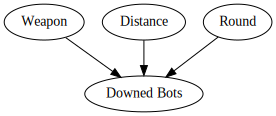

In [7]:
dag = gz.Digraph()
dag.node('w', 'Weapon')
dag.node('d', 'Distance')
dag.node('r', 'Round')
dag.node('b', 'Downed Bots')
dag.edges(['wb', 'db', 'rb'])
dag

Note that, since we randomized the experiment there is no other association between variables.

Even though this DAG is simple, thinking causally does not hurt. It is a way to communicate your assumptions in the data generating process. You might be worried about the DAG being wrong or not correct, this is totally understandable. But not thinking about the DAG and throwing all the variables in the model, which is done many times, is actually imposing a causal structure, which of course might not be the right one. So I recommend you to always spend a bit of time thinking about your data generating process, start simple and add complexity in a modular way.

## The Model

We build a binomial regression, with a logistic link:

$$log \frac{p}{1-p} = beta_i + round \cdot j$$

Where $beta_i$ is different for each combination of distance and weapon ($i$). $round$ is the coefficient associated with the learning as the rounds progressed. $j$ is the round but normalized to the maximum rounds played.

Note that we will be using uninformative priors. This is highly unrecommended but it is not covered in this analysis.

In [42]:
with pm.Model() as aim_model:
    
    # Uninformative Priors
    beta = pm.Normal('beta', mu=0, sigma=10, shape=len(values))
    round = pm.Normal('round', mu=0, sigma=10)

    # IDs
    treat_id = pm.intX(pm.ConstantData('treat_id', data['distance_weapon']))

    # Expected value of outcome
    log_odds = beta[treat_id] + round*(data['round']-1)/59
    p = pm.Deterministic('p', pm.math.invlogit(log_odds))

    # Likelihood
    bots = pm.Binomial('bots', n=N, p=p, observed=data['bots'])

We can take a look at the model structure of `PyMC`:

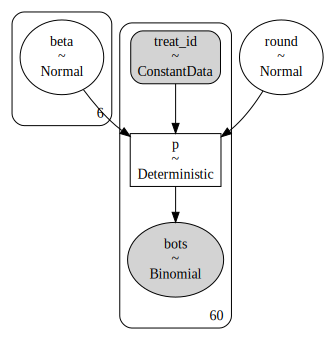

In [43]:
pm.model_to_graphviz(aim_model)

### Sampling

In [44]:
with aim_model:
    prior = pm.sample_prior_predictive(samples=1000, random_seed=rng)

Sampling: [beta, bots, round]


Note that we are using uninformative priors. This is highly unrecommended but it is not covered in this analysis. As a product of this our model has the prior belief that we either expect downing or 0 or 30 bots. This should be a great justification to find better priors:

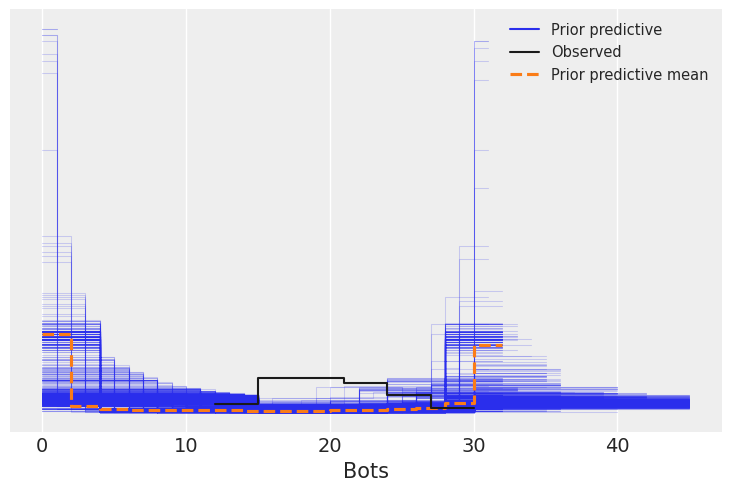

In [45]:
az.plot_ppc(prior, group='prior')
plt.xlabel('Bots')
plt.show()

In [46]:
with aim_model:
    inference_data = pm.sample()
    pm.sample_posterior_predictive(inference_data, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, round]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
Sampling: [bots]


After sampling from our model we can take a look at the posterior densities and check that their traces look OK (we want the to look noisy so samples are not correlated between them):

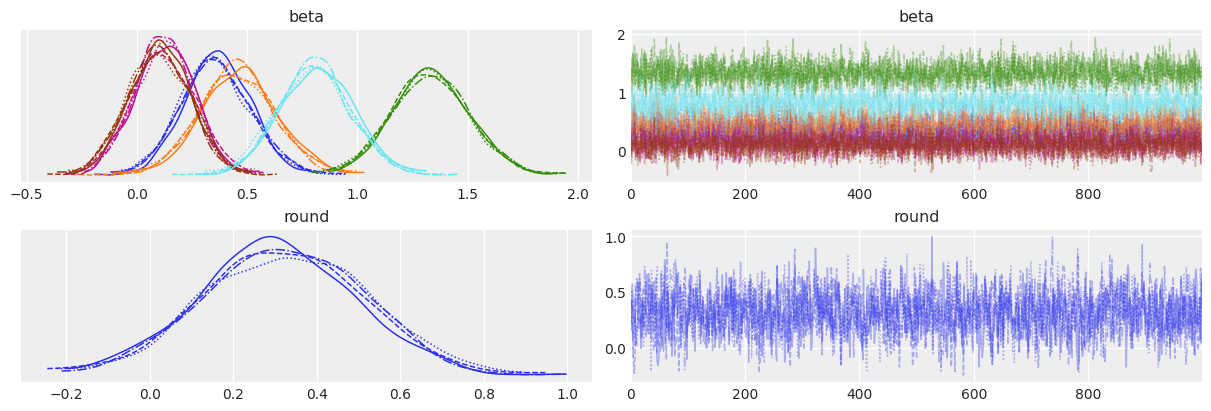

In [47]:
az.plot_trace(inference_data, var_names=['beta', 'round']);

We can then take a look at the summary:

In [83]:
az.summary(inference_data, var_names=['beta', 'round'], round_to=2, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.36,0.16,0.05,0.66,0.0,0.0,2605.53,3034.78,1.0
beta[1],0.46,0.17,0.13,0.82,0.0,0.0,2386.74,2655.28,1.0
beta[2],1.33,0.18,1.00,1.69,0.0,0.0,2984.57,2655.23,1.0
beta[3],0.12,0.14,-0.16,0.37,0.0,0.0,3247.40,2817.59,1.0
beta[4],0.10,0.14,-0.18,0.36,0.0,0.0,2816.88,3059.12,1.0
beta[5],0.81,0.16,0.48,1.12,0.0,0.0,2507.91,3210.56,1.0
round,0.32,0.19,-0.06,0.67,0.0,0.0,1782.20,2359.85,1.0


The $r\_hat$ values being `1.0` indicate a proper sampling from our model. We can also take a look at some statistics of our parameters, but making sense of them might be hard and in my opinion it is overrated, specially when working with Bayesian models: why making sense of a number, when you have a whole distribution to play with and understand its effect through simulations?

I am choosing to show a HDI (High Density Interval) with an area of 95%, this vastly comes from my nostalgia, any other value would be welcome.

Another check we can to is to compare the the observed data with the posterior distribution of our model:

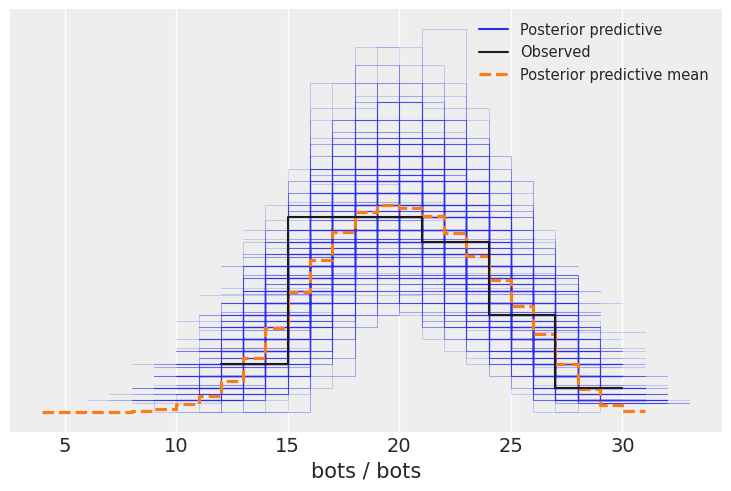

In [87]:
az.plot_ppc(inference_data, num_pp_samples=500)
plt.show()

We can also see it through the cumulative distribution:

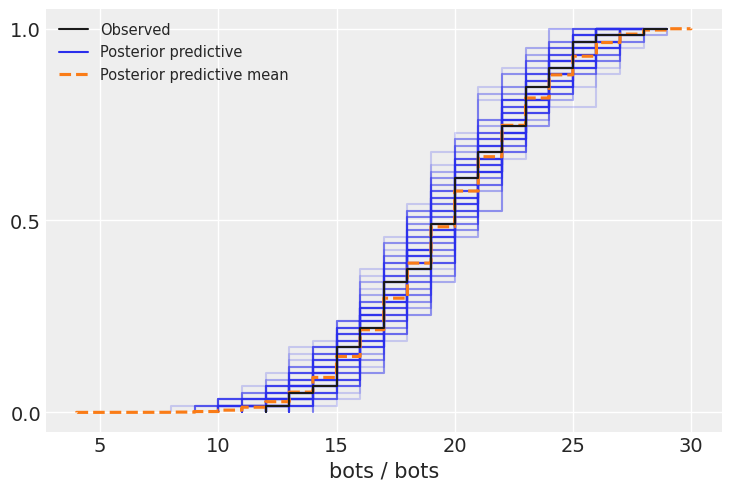

In [91]:
az.plot_ppc(inference_data, num_pp_samples=100, kind='cumulative')
plt.show()

### Parameters

My nostalgia is still driving me a little bit. Let's plot the _betas_ and their 95% HDI, this is done after the logistic transform, so what we are actually seeing is not the log-odds but the `p`'s.

And what are those? We can interpret them as the probability of downing one bot prior any training, that is, in the first round. We did not observe this in the data, since what we measured is out of 30 bots per round, how many did we shoot down. But how many success out of N trials is modeled by a Binomial distribution, with N equals to 30 (the number of bots per round) and `p`, the probability of success or, in our case, our accuracy.

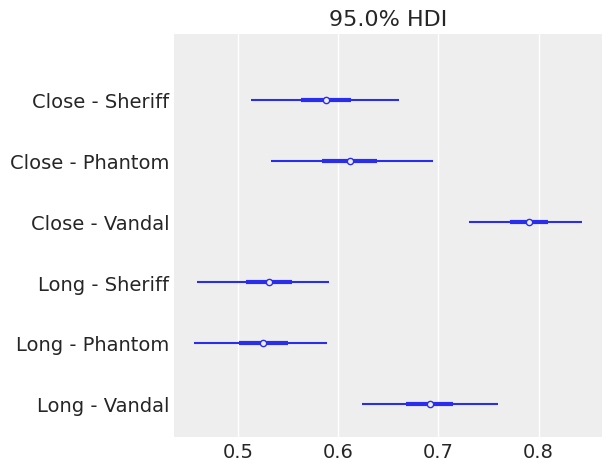

In [84]:
ax = az.plot_forest(inference_data, var_names=['beta'], transform=logistic, combined=True, hdi_prob=0.95)
ax[0].set_yticklabels(
    ['Long - Vandal',
     'Long - Phantom',
     'Long - Sheriff',
     'Close - Vandal',
     'Close - Phantom',
     'Close - Sheriff']
)
plt.show()

We can see here reflected some of the conclussions in the previous analysis:

* There is a drop in accuracy when going from close distance to long distance.
* The accuracy in the vandal is greater than the other two weapons.
* The accuracy with the phantom and sheriff is very similar.

While in the previous analysis we made the comparions by how many bots were downed, we are now making them by the actually accuracy which is more instrinsic characteristic.

#### Round

In the previous analysis we removed this variable from the model after testing for it's significance. What we will be doing now is averaging our accuracy from different weapons and distances in order to:

1. Meassure the improvement in accuracy after playing 60 rounds both in p.p. and %.
2. See how this change in accuracy translates to how the number of downed bots changes.

In [95]:
log_odds_start = inference_data.posterior['beta'].mean(axis=2)

p_start = logistic(log_odds_start)
p_end = logistic(log_odds_start + 1*inference_data.posterior['round'])

In [103]:
print(f'The starting accuracy is: {p_start.mean():.0%}, after playing 60 rounds, the accuracy was: {p_end.mean():.0%}')

The starting accuracy is: 63%, after playing 60 rounds, the accuracy was: 70%


Numbers are nice, but let's work with distributions, to better measure uncertainty. We do this in p.p. (percentage points):

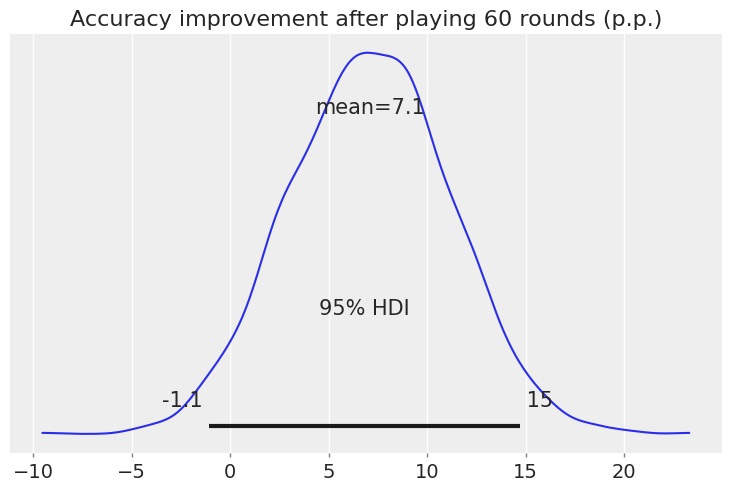

In [19]:
az.plot_posterior(100*(p_end - p_start), hdi_prob=0.95)
plt.title('Accuracy improvement after playing 60 rounds (p.p.)')
plt.show()

And in relative increase (%):

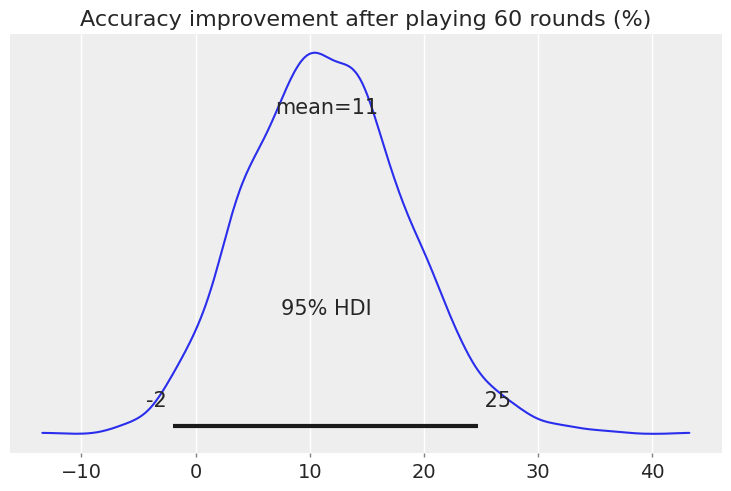

In [20]:
az.plot_posterior(100*(p_end - p_start)/p_start, hdi_prob=0.95)
plt.title('Accuracy improvement after playing 60 rounds (%)')
plt.show()

After training, we observe an overall increment in accuracy, `11%` on average. Most of the density is possitive, but there is great uncertainty: 95% of the probability mass is between -2% and +25%.

Let's see how this increment in precission translates to number of downed bots. We do this by means of simulating rounds with the precissions before and after training. Since we are not using averages but whole distributions, the undertainty in our `p`'s are translated to the number of downed bots. This was not done in the previous analysis since the confidence intervals used are for the mean of the distribution, not the actual distribution.

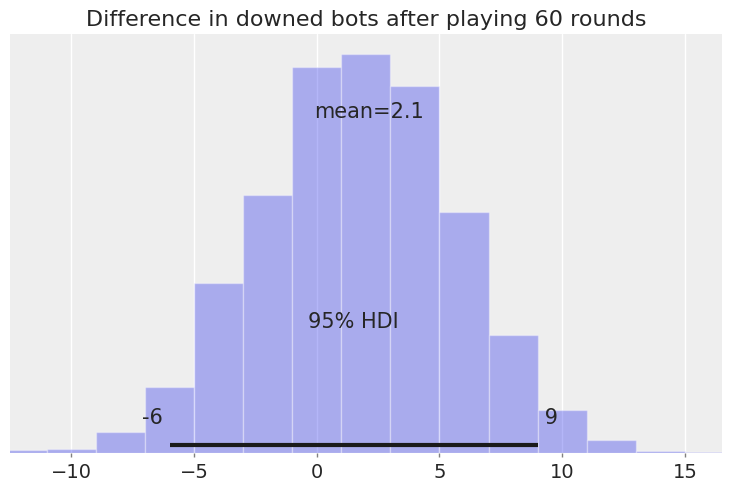

In [111]:
simulating_contrast = np.random.binomial(N, p_end) - np.random.binomial(N, p_start)
az.plot_posterior(simulating_contrast, hdi_prob=0.95)
plt.title('Difference in downed bots after playing 60 rounds')
plt.show()

Although the average difference is possitive, there is great uncerainty around how many donwed bots we expect to do after training.

Since we have the whole distribution we can query questions such as:

After playing 60 rounds, what is the probability of downing more bots than without training?

In [119]:
print(f'The probability is {(simulating_contrast > 0).mean():.0%}')

The probability is 66%


After playing 60 rounds, what is the probability of downing `5` more bots than without training?

In [123]:
print(f'The probability is {(simulating_contrast >= 5).mean():.0%}')

The probability is 28%


Querying a model like this is just awesome!

#### Distance

We now take a look at the effect of the distance. We average the precision between weapons and check what is the loss of accuracy when going further from the target.

In [112]:
log_odds_close = inference_data.posterior['beta'][:, :, :3].mean(axis=2)
p_close = logistic(log_odds_close)

log_odds_long = inference_data.posterior['beta'][:, :, 3:].mean(axis=2)
p_long = logistic(log_odds_long)

These is the decrease in accuracy in percentage points:

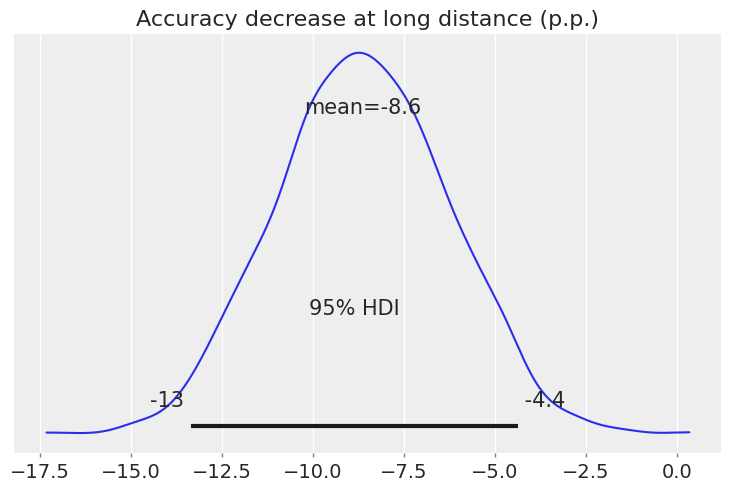

In [23]:
az.plot_posterior(100*(p_long - p_close), hdi_prob=0.95)
plt.title('Accuracy decrease at long distance (p.p.)')
plt.show()

This absolute differences translate to this relative difference (%):

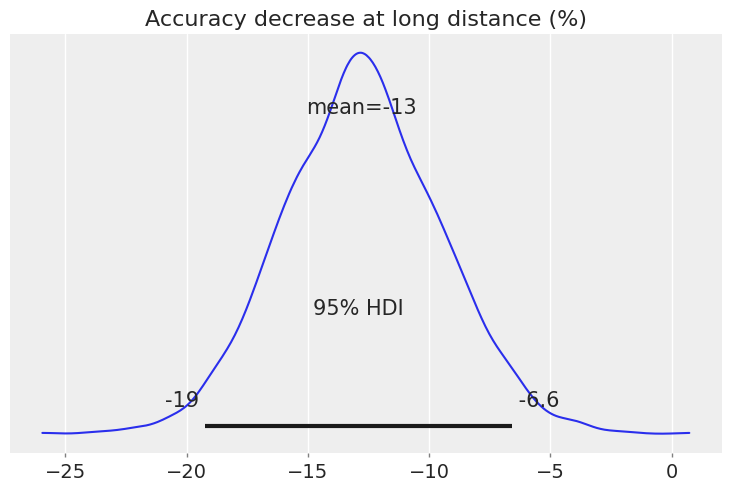

In [127]:
relative_difference = (p_long - p_close)/p_close 
az.plot_posterior(100*relative_difference, hdi_prob=0.95)
plt.title('Accuracy decrease at long distance (%)')
plt.show()

Going to the long distance implied a loss of `13%` in accuracy, and this difference is notably negative. The 95% HDI ranges between `6.6%` and `19%`. As done before, we can query our model and check how much area we have below zero:

In [133]:
print(f'The area below zero is {(relative_difference < 0).mean():.3%}')

The area below zero is 99.975%


The model believes that the effect on distance is moslty negative.

Of course knowing the decrease in accuracy is important, what does this decrease and the uncertainty of this parementer translate to the number of downed bots?

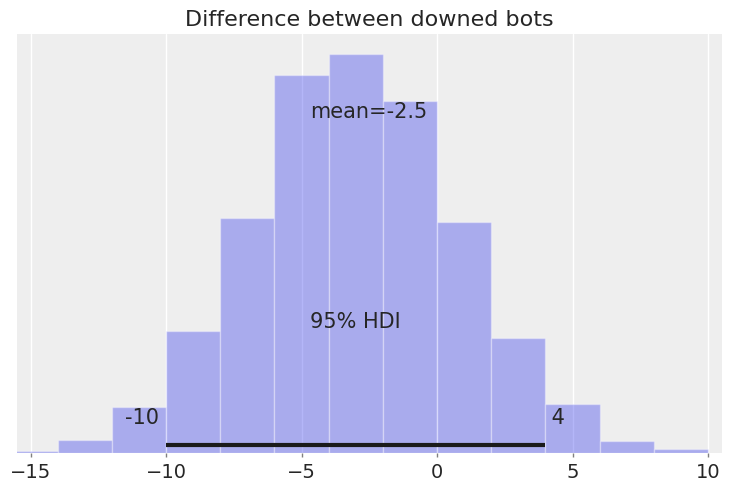

In [134]:
distance_contrast = np.random.binomial(N, p_long) - np.random.binomial(N, p_close)
az.plot_posterior(distance_contrast, hdi_prob=0.95)
plt.title('Difference between downed bots')
plt.show()

Even though the effect of the distance is mostly negative, the difference in downed bots is not: the 95% HDI is between `-10` and `4`.

This might surprise the reader, but hopefully the following exercise clarifies that due to the randomness in the process, not always the higher precission will win a round.

Let's run a simulation where we have player 1, with `p=0.8` and player 2 with `p=0.7`. Player 1 does have a better accuracy than player 2. Holding the accuracy constant, if they play 1000 rounds will player 1 always down more bots than player 2?

I encourage the reader to think a little bit before looking at the following numbers.

In [155]:
rounds = 1000

p_1 = 0.8
p_2 = 0.7

bots_1 = np.random.binomial(N, p_1, rounds)
bots_2 = np.random.binomial(N, p_2, rounds)

sim_contrast = bots_2 - bots_1
sim_hdi = az.hdi(sim_contrast, hdi_prob=0.95)

print(f'Player 1 had more downed bots than player 2 in {(bots_1 > bots_2).sum()} out of {rounds} rounds.\nThe 95% HDI of the difference is [{sim_hdi[0]}, {sim_hdi[1]}] and the mean is {sim_contrast.mean():.1f} bots.')

Player 1 had more downed bots than player 2 in 809 out of 1000 rounds.
The 95% HDI of the difference is [-9, 3] and the mean is -3.2 bots.


Aha! Player 1 is not always the winner, even though it has `+10 p.p.` in accuracy than player 2. Hopefully this sheds some light onto the previous obtained results.

Note that, even though the accuracies of both players were fixed numbers, there is uncertainty on who will win due to the data generating process. When prior to this excersice we used the model to check for differences, we generated the differences not with the mean values of the accuracies at close and long distance, but with the whole posterior distribution. This is really important, since our estimate on the difference of downed bots has not only the uncertainty of the data generating process, but also the uncertainty of our estimates on the precission!

#### Weapons: Vandal vs Phantom

Last, but not least, we come back to the comparison between the Phantom and the Vandal.

In [26]:
log_odds_phantom = inference_data.posterior['beta'][:, :, [1,4]].mean(axis=2)
p_phantom = logistic(log_odds_phantom)

log_odds_vandal = inference_data.posterior['beta'][:, :, [2,5]].mean(axis=2)
p_vandal = logistic(log_odds_vandal)

In terms of shooting down bots, we can take a look at the relative differences:

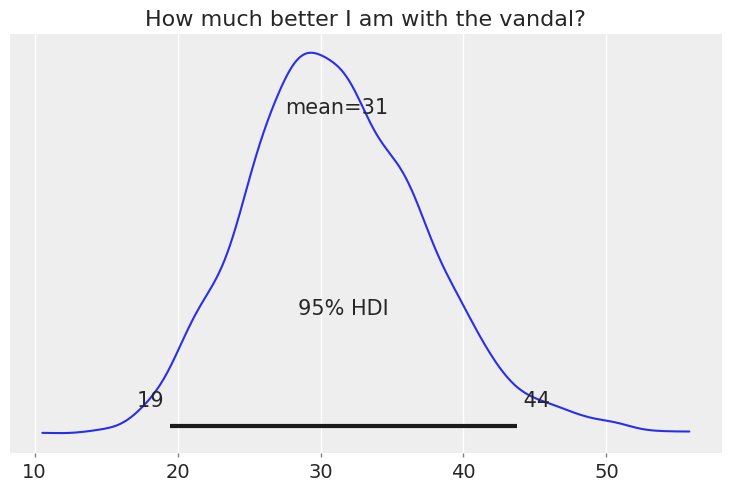

In [157]:
az.plot_posterior(100*(p_vandal - p_phantom)/p_phantom, hdi_prob=0.95)
plt.title('How much better I am with the vandal?')
plt.show()

Overall, we can see that the accuracy with the vandal is `31%` than with the phantom. All of the mass is above 0%, the 95% HDI is between `19%` and `44%`.

This difference in accuracy translates to the following number of downed bots:

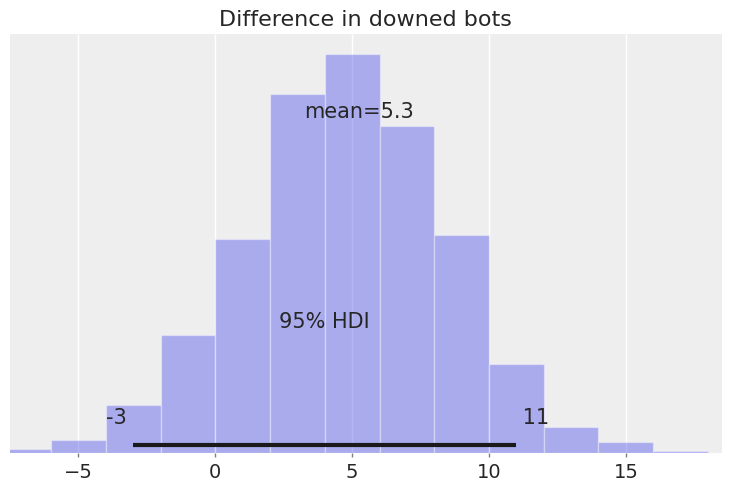

In [159]:
weapon_contrast = np.random.binomial(N, p_vandal) - np.random.binomial(N, p_phantom)
az.plot_posterior(weapon_contrast, hdi_prob=0.95)
plt.title('Difference in downed bots')
plt.show()

We should expect to down 5.3 more bots on average with the Vandal.

In [161]:
print(f'The probability of downing less bots with the Vandal than the Phantom is: {(weapon_contrast < 0).mean():.1%}')

The probability of downing less bots with the Vandal than the Phantom is: 6.2%


We finish the analysis by showing the distribution of downed bots of the Phantom and the Vandal at close and long distance:

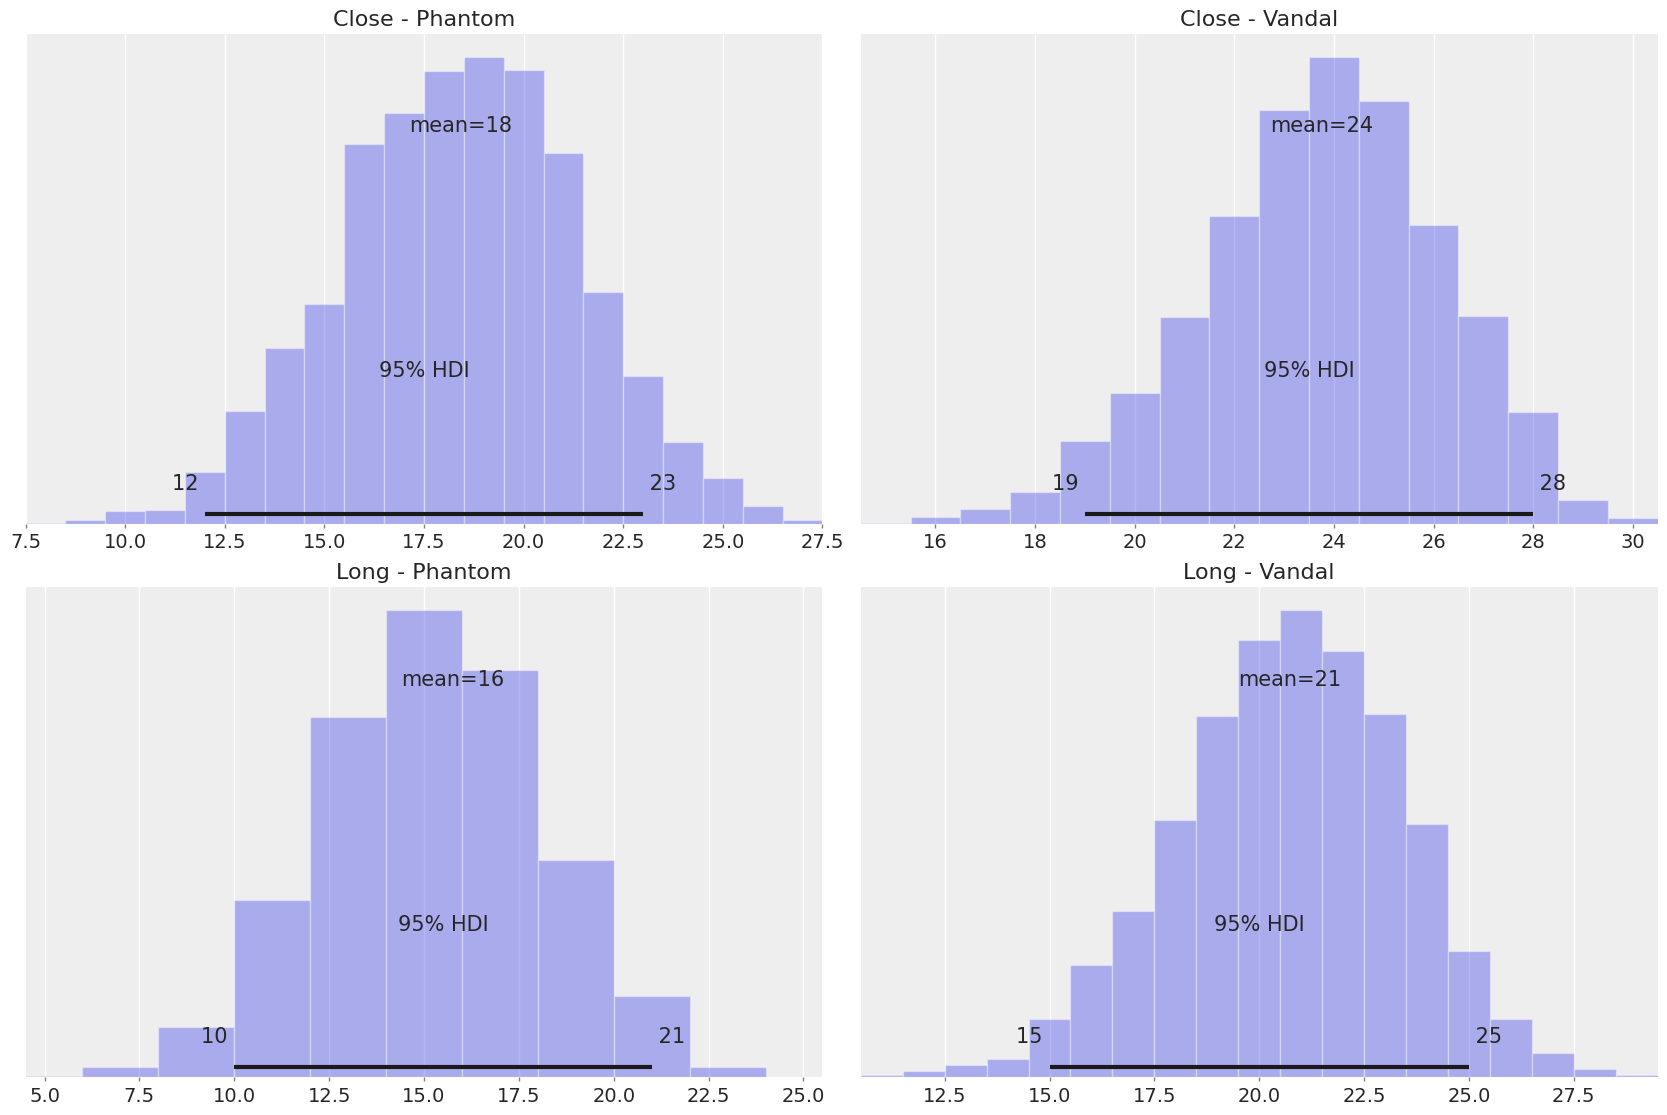

In [169]:
posteriors = np.random.binomial(N, logistic(inference_data.posterior['beta'][:, :, [1,2,4,5]]))
ax = az.plot_posterior(posteriors, grid=(2,2), hdi_prob=0.95)
ax[0, 0].set_title('Close - Phantom')
ax[0, 1].set_title('Close - Vandal')
ax[1, 0].set_title('Long - Phantom')
ax[1, 1].set_title('Long - Vandal')
plt.show()